In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from simulation_utils import *
from sklearn.manifold import MDS
from sklearn.metrics import euclidean_distances, DistanceMetric, auc, f1_score, mutual_info_score
from sklearn.metrics.pairwise import manhattan_distances, cosine_distances
from sklearn.cluster import KMeans
import scipy.stats as stat
from scipy.optimize import minimize
import itertools
# import ipyparallel as ipp
from collections import defaultdict
import pymc as pm
from sklearn.mixture import GaussianMixture
from scipy.spatial.distance import jensenshannon
import matplotlib.animation as animation


In [12]:
stimuli = np.random.uniform(size=(15, 10))
feature_encode_prob = 0.9
correct_encode_prob = 0.6
time_unit = 5
test_stimuli = np.random.uniform(size = (15, 10))





In [20]:
encoded_stimuli = np.zeros((15, 10))

for s, stim in enumerate(stimuli):
    for t in range(time_unit):
        for f, feat in enumerate(stim):
            if encoded_stimuli[s][f] != 0:
                
                # print('here')
                continue
            else:
                if np.random.uniform() < feature_encode_prob:
                    if np.random.uniform() < correct_encode_prob:
                        encoded_stimuli[s][f] = stimuli[s][f]
                    else:
                        encoded_stimuli[s][f] = np.random.uniform()
    

<Axes: >

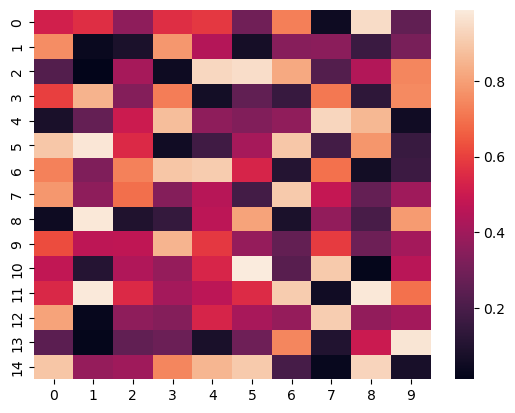

In [22]:
sns.heatmap(stimuli)

In [ ]:
def get_encoded(store_prob_alpha, store_prob_beta, encode_noise, stim_stream, obj_cat_feature_matrix, context_boost = False, node_entropy = None):
    encoder = np.zeros((len(stim_stream), obj_cat_feature_matrix.shape[1]))
    # forgetting_rate = 0.05
    # encoding_rate = 0.9
    if not context_boost:
        for i, stim in enumerate(stim_stream):
            for feature in range(obj_cat_feature_matrix.shape[1]):
                store_prob = np.random.beta(store_prob_alpha, store_prob_beta)
                acc_prob = np.random.beta(store_prob_alpha, store_prob_beta)

                if np.random.binomial(1, store_prob):
                    if np.random.binomial(1, acc_prob):
                        encoder[i][feature] = obj_cat_feature_matrix[stim][feature] 
                    else:
                        encoder[i][feature] = obj_cat_feature_matrix[stim][feature] + np.random.normal(obj_cat_feature_matrix[stim][feature], encode_noise)
                else:
                    encoder[i][feature] = 0
    else:
        for i, stim in enumerate(stim_stream):
            for feature in range(obj_cat_feature_matrix.shape[1]):
                store_prob = np.random.beta(store_prob_alpha*node_entropy[stim], store_prob_beta/node_entropy[stim])
                acc_prob = np.random.beta(store_prob_alpha*node_entropy[stim], store_prob_beta/node_entropy[stim])

                if np.random.binomial(1, store_prob):
                    if np.random.binomial(1, acc_prob):
                        encoder[i][feature] = obj_cat_feature_matrix[stim][feature] 
                    else:
                        encoder[i][feature] = obj_cat_feature_matrix[stim][feature] + np.random.normal(obj_cat_feature_matrix[stim][feature], encode_noise)
                else:
                    encoder[i][feature] = 0
        

    return encoder
